### Audio Feature Analysis

The goal of this analysis is to 'map out' regions whose activity tracks with the RMSE of the speech soundtrack.
This script will load a variable 'resampled_audio_feature', which contains the time-varying RMSE (roughly, the sound energy) as a variable. This variable has been resampled to match the temporal resolution of fMRI (because speech is much faster). Moreover, when we correlate this audio-feature against the fmri-data, we will account for the time-delay between the sound and the fMRI response (so-called hemodynamic lag).

In [1]:
import re, sys
import nilearn
from nilearn import plotting, input_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/opt/anaconda3/envs/neuroimaging/lib/python3.9/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


### Load relevant data

1. extracted audiofeature (RMSE)
2. extracted fMRI data

In [2]:
resampled_audio_feature = np.load('../data_pieman/resampled_audio_feature.npy')
print(resampled_audio_feature.shape)

fmri_data = np.load('../data_pieman/fmri_data_pieman.npy')
print(fmri_data.shape)

(300,)
(68, 300, 293)


### Group-average the fMRI data

In [3]:
resmat_all = np.nanmean(fmri_data, axis = 0)
resmat_all.shape

(300, 293)

In [4]:
#plt.figure(figsize = (20,2))
#plt.plot(resampled_audio_feature)


### Correlate the time-varying audio-feature against the neural measuements (for each region)

In [61]:
res = []
tr_shift = 3

for i in range(268):
    #print(i)
    res.append(np.corrcoef(resmat_all[tr_shift:,i], resampled_audio_feature[:-tr_shift])[0,1])
    
#plt.plot(res);

print(np.argmax(res))

print(np.max(res))

162
0.3539958651763675


In [63]:
res

[-0.02508355239044223,
 -0.13413993185002812,
 -0.1579756658533565,
 -0.04574932198855397,
 -0.16454375009413713,
 -0.12274047776468111,
 -0.04177892615718231,
 -0.04889250295871139,
 -0.10676892946361238,
 -0.10526352754835445,
 -0.06449842505876775,
 -0.08158825601285187,
 -0.13483964238239182,
 -0.01899749119071128,
 -0.12821832365130756,
 -0.0437470373866548,
 -0.05455569024144217,
 0.020090917606578183,
 -0.05431731141606428,
 -0.139208911591244,
 -0.08559706240650355,
 -0.009478317345034088,
 -0.04746409832360438,
 -0.0860007518799149,
 0.026334136689368,
 -0.018541319168832754,
 0.03564381528316514,
 -0.0816438484826031,
 -0.12874446237781864,
 -0.07898547369803206,
 -0.02259504956298739,
 -0.02870278950786377,
 -0.05295006147331553,
 0.08881927255401387,
 -0.019544801011922165,
 -0.07413021562768399,
 0.17131264272756644,
 -0.06296230920835502,
 -0.10794903995205504,
 0.24363315498452767,
 -0.018831778873089736,
 -0.0899887384261867,
 -0.011785919254744003,
 -0.0191206801031958

In [64]:
np.where(np.asarray(res)>0.15)

(array([ 36,  39,  45,  60,  61, 162, 169, 172, 179, 180, 190]),)

In [66]:
res[61]

0.32154256081328164

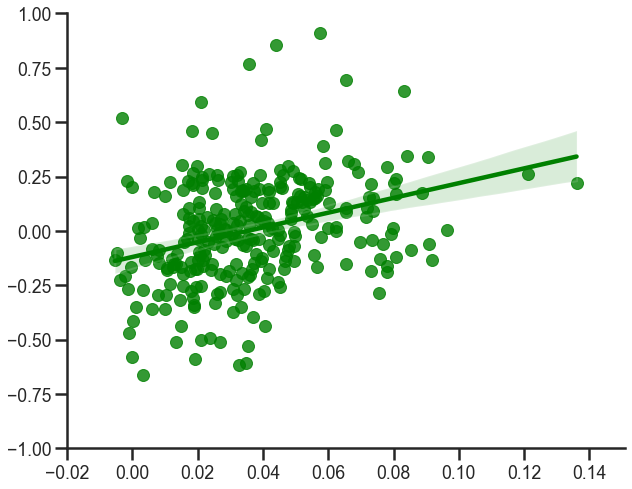

In [69]:
i = 61

sns.set_style('ticks')
plt.figure(figsize = (10, 8))
sns.regplot(
            resampled_audio_feature[:-tr_shift],
            resmat_all[tr_shift:,i], 
            color = 'Green')
plt.ylim([-1,1])
plt.xlim([-0.02,0.151])

sns.despine()

8000


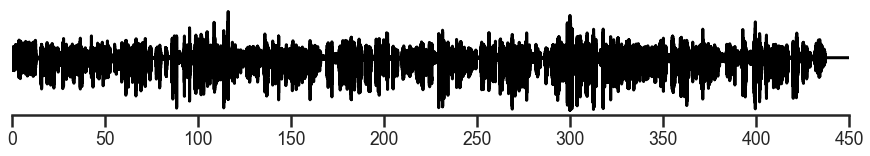

In [11]:
import seaborn as sns
from scipy.io.wavfile import write

from IPython.display import Audio
from scipy.io import wavfile

sound_file = '../data_pieman/pieman.wav'
samplerate, sounddata = wavfile.read(sound_file)
#print(data.shape[0]/samplerate)
print(samplerate)
sns.set_context("poster", font_scale = 0.8, rc={"grid.linewidth": 0.6});
sns.set_style('ticks')

plt.figure(figsize= (15,2));
plt.plot(sounddata, color ='black');
plt.xlim([0,sounddata.shape[0]]);
sns.despine(left=True);
plt.yticks([]) ;
plt.xlim([0, sounddata.shape[0]]);
plt.xticks(np.arange(0,sounddata.shape[0]+1, 50*samplerate), np.arange(0,451,50));
#plt.xticklabels(np.arange(0,450,50));


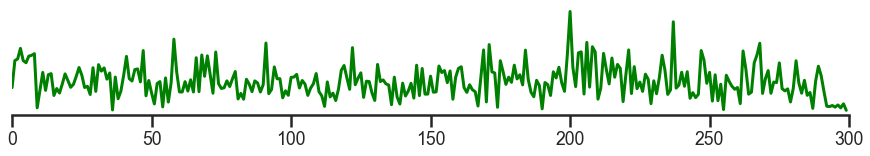

In [70]:
plt.figure(figsize= (15,2));

plt.plot(resampled_audio_feature, color = 'green')
sns.despine(left=True);
plt.yticks([]) ;
plt.xlim([0,300]);

#plt.xticklabels(np.arange(0,450,50));

### Load the brain parcellation to visualize the results

In [6]:
shen_file       = '../data_pieman/shen_2mm_268_parcellation.nii'
'''
nilearn.plotting.plot_roi(shen_file, 
                  annotate = False, 
                  cut_coords = (5,0,0),
                  cmap = 'prism',
                  draw_cross = False, 
                  #title= 'Shen-268-node parcellation',
                 );'''
shen_masker = nilearn.input_data.NiftiLabelsMasker(labels_img=shen_file);

sample_file = '../data_pieman/func.nii'
shen_masker.fit_transform(sample_file);

### Threshold the results and visualize: Which brain regions track with the audio-feature?

(1, 268)


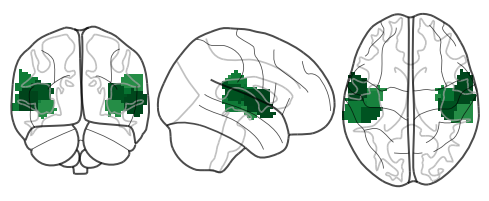

In [72]:
res = np.asarray(res)
res[res < 0.1] = 0

r2 = np.reshape(res, (1,268))
print(r2.shape)

res_img = shen_masker.inverse_transform(r2);
plotting.plot_glass_brain(nilearn.image.index_img(res_img,0), 
                          colorbar=False, 
                          annotate = False,
                          cmap="Greens", 
                          threshold=0.15,
                          plot_abs=False, 
                          #display_mode='x',
                          #figure=plt.figure(figsize=(4, 4)),
                         );

(1, 268)


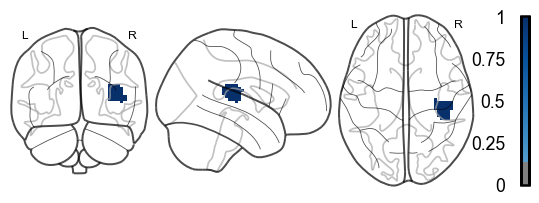

In [67]:


r2 = np.zeros((1,268))
r2[0,61] = 1
print(r2.shape)

res_img = shen_masker.inverse_transform(r2);
plotting.plot_glass_brain(nilearn.image.index_img(res_img,0), 
                          colorbar=True, 
                          annotate = True,
                          cmap="Blues", 
                          threshold=0.15,
                          plot_abs=False, 
                          #display_mode='x',
                          #figure=plt.figure(figsize=(4, 4)),
                         );

### For comparison: Brain regions involved in "all things auditory" (from NeuroSynth.org)

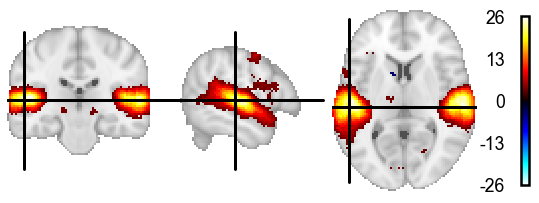

In [30]:
plotting.plot_stat_map('../data_pieman/auditory_association-test_z_FDR_0.01.nii.gz', 
                          colorbar=True, 
                          annotate = False,
                          #cmap = 'Greens',
                          #threshold=6.15,
                          #plot_abs=True, 
                         # display_mode='x',
                         # figure=plt.figure(figsize=(4, 4)),
                         );

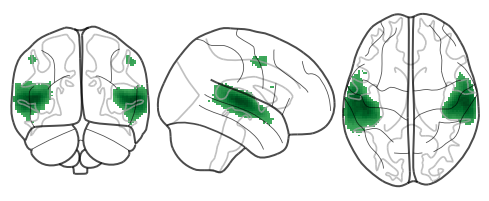

In [73]:
plotting.plot_glass_brain('../data_pieman/auditory_association-test_z_FDR_0.01.nii.gz', 
                          colorbar=False, 
                          cmap = 'Greens',
                          annotate = False,
                          threshold=6.15,
                          plot_abs=True, 
                          #display_mode='x',
                         # figure=plt.figure(figsize=(4, 4)),
                         );

### heap

In [ ]:
#res_img = shen_masker.inverse_transform(r2);
#view = nilearn.plotting.view_img(  nilearn.image.index_img(res_img,0), 
#                                     threshold = 0.0, 
#                                     vmax = 0.2, 
#                              );
#view

In [ ]:
#view = nilearn.plotting.view_img(  '../data_pieman/auditory_association-test_z_FDR_0.01.nii.gz', 
#                                     threshold = 0.0, 
#                                     #vmax = 0.2, 
#                              );
#view

In [ ]:
resmat_all.shape

In [ ]:
from scipy.stats import zscore

In [ ]:
plt.figure(figsize = (10,2))
plt.plot(zscore(resmat_all[2:,162]));
plt.plot(zscore(resampled_audio_feature[:-2]));

In [ ]:
plt.scatter(zscore(resmat_all[2:,162]),
            zscore(resampled_audio_feature[:-2]));
plt.axis('square');